Generating turbidity predictions using Model 1...
Generating diatom predictions using Model 2...


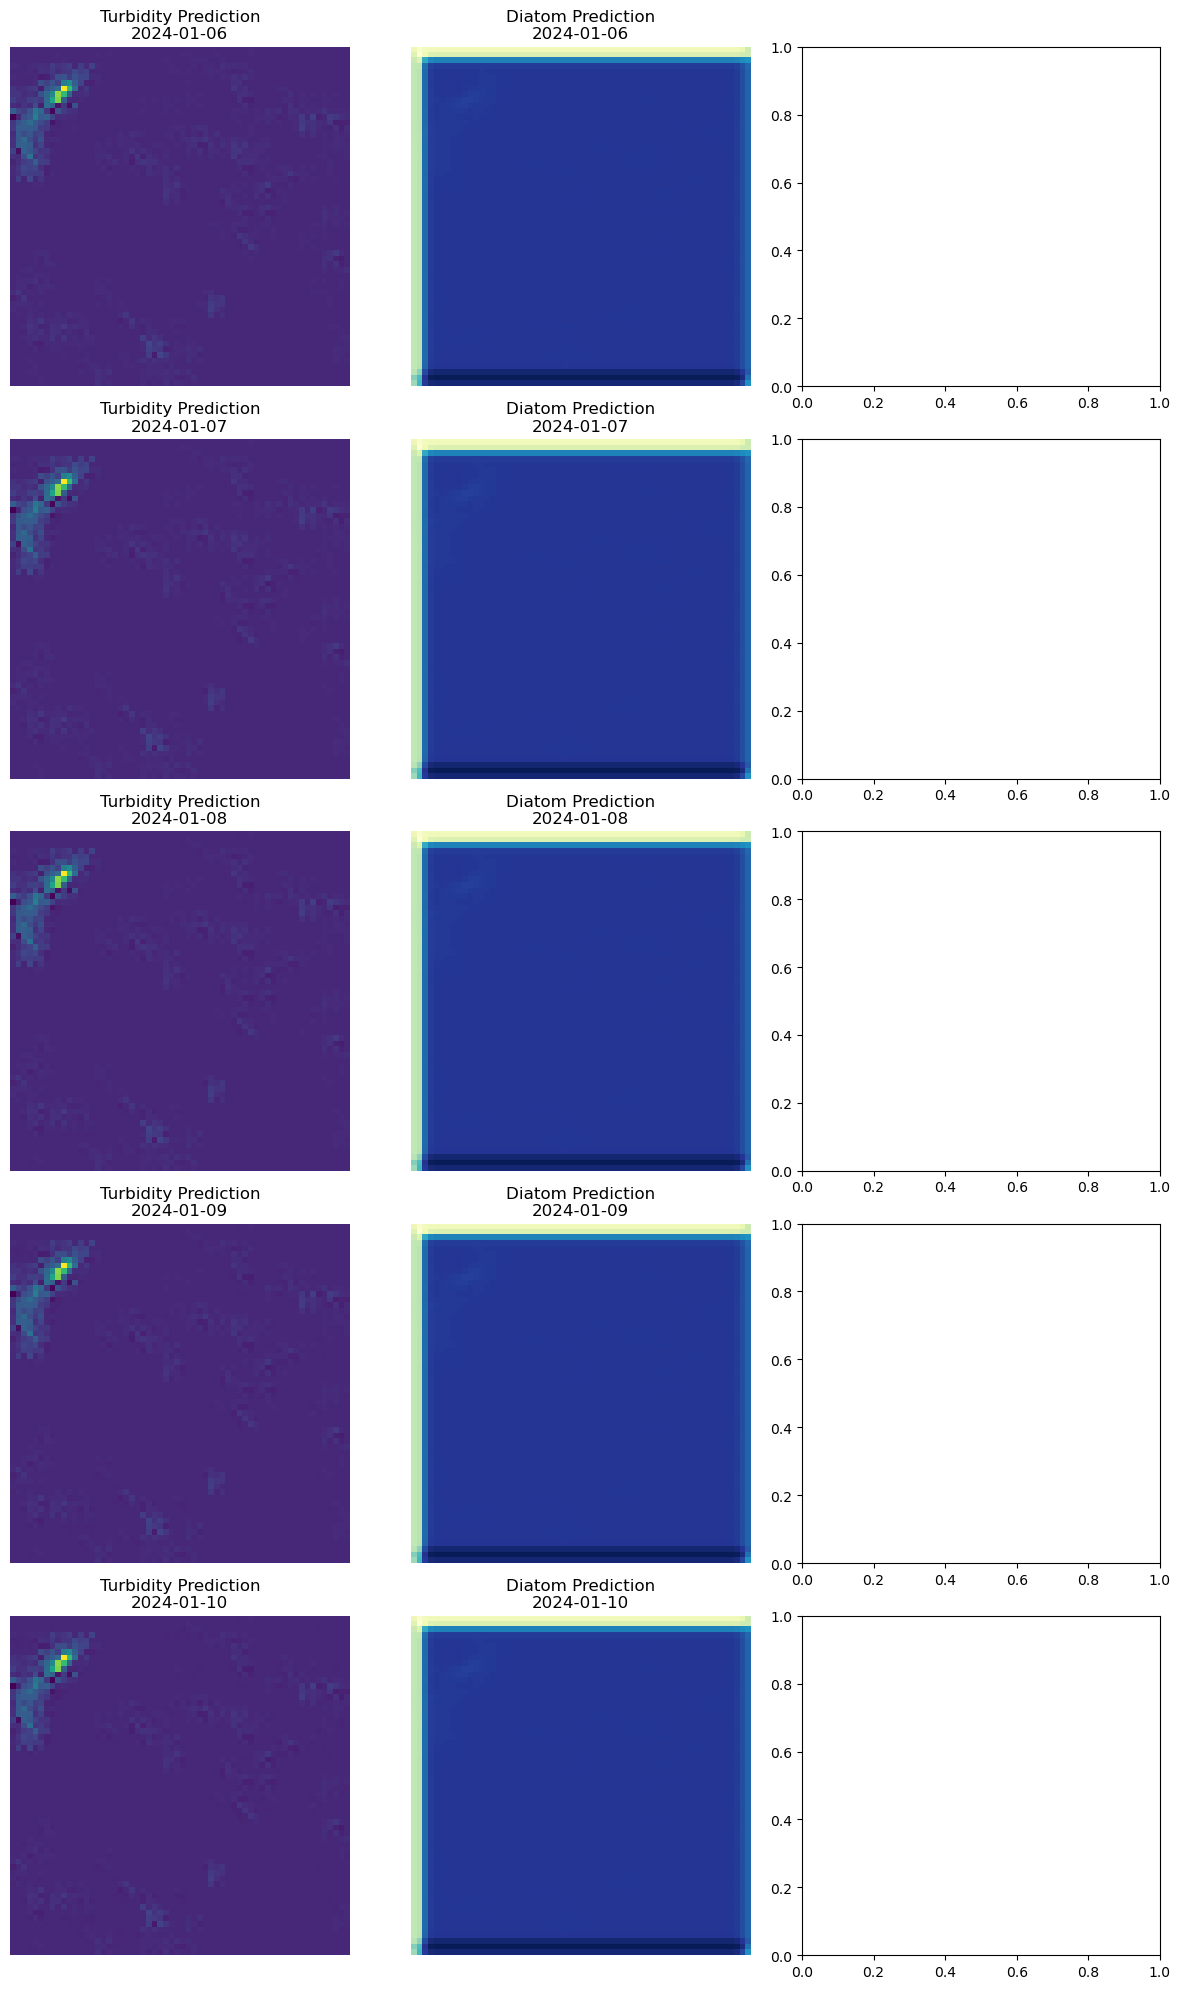

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load models
model1 = load_model("/home/user/MSc/Clean_Codebase/models/model1_dam_to_turbidity.h5", compile=False)
model2 = load_model("/home/user/MSc/Clean_Codebase/models/model2_turbidity_to_diatom.h5", compile=False)

# Define prediction period
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 1, 10)

# Function to predict turbidity
def predict_turbidity(date, dam_on=True):
    day_of_year = date.timetuple().tm_yday
    sin_doy = np.sin(2 * np.pi * day_of_year / 365)
    cos_doy = np.cos(2 * np.pi * day_of_year / 365)
    dam_flag = 1 if dam_on else 0

    input_vec = np.array([[dam_flag, sin_doy, cos_doy]])
    pred = model1.predict(input_vec, verbose=0)[0]
    return pred.reshape(60, 60)

# Generate turbidity predictions
print("Generating turbidity predictions using Model 1...")
turbidity_stack = []
dates = []
date = start_date
while date <= end_date:
    turbidity = predict_turbidity(date)
    turbidity_stack.append(turbidity)
    dates.append(date.strftime("%Y-%m-%d"))
    date += timedelta(days=1)
turbidity_stack = np.array(turbidity_stack)

# Prepare turbidity sequences for Model 2
sequence_length = 5
input_sequences = []
target_dates = []
for i in range(len(turbidity_stack) - sequence_length):
    seq = turbidity_stack[i:i + sequence_length]
    input_sequences.append(seq)
    target_dates.append(dates[i + sequence_length])
input_sequences = np.array(input_sequences)[..., np.newaxis]

# Generate Diatom Predictions
print("Generating diatom predictions using Model 2...")
diatom_preds = model2.predict(input_sequences, verbose=0)

# Plot all predictions
num_preds = len(diatom_preds)
fig, axes = plt.subplots(num_preds, 3, figsize=(12, 4 * num_preds))

for i in range(num_preds):
    turb_day = input_sequences[i][-1, :, :, 0]
    diat_pred = diatom_preds[i, :, :, 0]
    diff = diat_pred - turb_day

    # Row layout (if single prediction, axes is 1D)
    row_axes = axes[i] if num_preds > 1 else axes

    row_axes[0].imshow(turb_day, cmap="viridis")
    row_axes[0].set_title(f"Turbidity Prediction\n{target_dates[i]}")
    row_axes[0].axis("off")
    row_axes[1].imshow(diat_pred, cmap="YlGnBu")
    row_axes[1].set_title(f"Diatom Prediction\n{target_dates[i]}")
    row_axes[1].axis("off")


plt.tight_layout()
plt.show()
